<a href="https://colab.research.google.com/github/archit436/Birds_Classifier/blob/main/Models/Main_Models/Main_Model_Audio_Main_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


0. Setup


In [70]:
# Start by importing the relevant libraries.
# Copied from Archit's Lab 3 Submission and then some more.
import os
import glob
import pandas as pd
import numpy as np
import pickle
import time
import torch
import itertools
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio
import torchaudio.transforms as T
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Subset, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

1. Data Processing - WAV Tensors Spectograms


In [71]:
# Start by loading the birds dataframe for deets on birds to classify.
birds_df = pd.read_csv('../../Data Processing/chosen_classes_47_data_stats.csv')
birds_df.head()

,Index,Class ID,Images Count,XC Recordings Count,Species Name,XC Species Name
0,0,315,116,169,Gadwall (Breeding male),Gadwall
1,1,317,120,243,Mallard (Breeding male),Mallard
2,2,352,120,283,Black-crowned Night-Heron (Adult),Black-crowned Night Heron
3,3,400,117,335,Herring Gull (Adult),Herring Gull
4,4,450,120,365,Common Tern,Common Tern


In [72]:
# Start by importing the tensors stored in the .pt files, one for each class.
# Define the directory of the audio data.
wav_tensors_dir = '../../Data/Xeno_Canto_WAV_Spectrograms_10sec'
# Define a list to store the tensors and associated labels.
all_features = []
all_labels = []

# Iterate through each bird, importing only the ones in birds_df.
for file in os.listdir(wav_tensors_dir):
    # Check if the file is a .pt file.
    if(file.endswith('.pt') == False):
        continue
    # Load the pt file.
    pt_file = glob.glob(os.path.join(wav_tensors_dir, file))
    # Error check
    if(pt_file == []):
        continue
    # Extract features and create labels in tensors.
    features_tensor = torch.load(pt_file[0])
    label_value = int(os.path.splitext(file)[0])
    labels_tensor = torch.full((features_tensor.shape[0],), label_value, dtype=torch.long)
    # Check if the label is in the birds_df dataframe.
    if label_value not in birds_df['Class ID'].values:
        continue
    # Add these tensors to their respective lists.
    all_features.append(features_tensor)
    all_labels.append(labels_tensor)
    print(f"Bird {label_value} loaded with {features_tensor.shape[0]} samples.")

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_11770/4054560578.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features_tensor = torch.load(pt_file[0])


Bird 539 loaded with 170 samples.
Bird 352 loaded with 285 samples.
Bird 317 loaded with 240 samples.
Bird 979 loaded with 331 samples.
Bird 848 loaded with 181 samples.
Bird 949 loaded with 150 samples.
Bird 877 loaded with 284 samples.
Bird 774 loaded with 211 samples.
Bird 802 loaded with 500 samples.
Bird 847 loaded with 210 samples.
Bird 832 loaded with 500 samples.
Bird 513 loaded with 351 samples.
Bird 946 loaded with 175 samples.
Bird 527 loaded with 335 samples.
Bird 536 loaded with 500 samples.
Bird 957 loaded with 223 samples.
Bird 543 loaded with 184 samples.
Bird 856 loaded with 500 samples.
Bird 902 loaded with 500 samples.
Bird 852 loaded with 279 samples.
Bird 796 loaded with 500 samples.
Bird 746 loaded with 208 samples.
Bird 871 loaded with 499 samples.
Bird 400 loaded with 335 samples.
Bird 830 loaded with 289 samples.
Bird 756 loaded with 261 samples.
Bird 875 loaded with 202 samples.
Bird 964 loaded with 156 samples.
Bird 886 loaded with 172 samples.
Bird 810 loade

In [73]:
# Print the number of classes for which data has been extracted.
num_classes = len(all_labels)
print(f"Number of classes for which data has been extracted: {num_classes}")

Number of classes for which data has been extracted: 47


In [74]:
# Error check for type of tensors.
all_features[0].dtype

torch.float32

In [75]:
# Concatenate all the tensors into one tensor.
features_tensor = torch.cat(all_features, dim=0)
labels_tensor = torch.cat(all_labels, dim=0)

print("Concatenation complete.")

# Encode the labels to make them suitable for training the model.
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_tensor)
# Create mapping dictionaries for the encoding.
id_to_index = dict(zip(labels_tensor, encoded_labels))
index_to_id = dict(zip(encoded_labels, labels_tensor))

print("Encoding complete.")

# Pickle dump these mappings for use later.
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump({'id_to_index': id_to_index, 'index_to_id': index_to_id}, f)

print("Mappings pickled.")

# Replace the labels tensor.
labels_tensor = torch.from_numpy(encoded_labels)

# Print out stats.
print(f"Shape of features tensor: {features_tensor.shape}")
print(f"Shape of labels tensor: {labels_tensor.shape}")

Concatenation complete.
Encoding complete.
Mappings pickled.
Shape of features tensor: torch.Size([13407, 1, 128, 128])
Shape of labels tensor: torch.Size([13407])


In [37]:
# Now we move on to splitting the data into training, validation, and test sets.
# We will use a stratified split to ensure uniform distribution of classes.

# Get labels as numpy array.
labels_np = labels_tensor.numpy()
# Use the labels np array to create indices array.
indices = np.arange(len(labels_np))

# First Split: train + val vs test - 80:20
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
temp_idx, test_idx = next(sss1.split(indices, labels_np))

# Get the temporary set.
temp_indices = np.arange(len(temp_idx))
temp_labels_np = labels_np[temp_idx]

# Second Split: train vs val - 80:20
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_temp_idx, val_temp_idx = next(sss2.split(temp_indices, temp_labels_np))

# Convert to original indices.
train_idx = temp_idx[train_temp_idx]
val_idx = temp_idx[val_temp_idx]

In [38]:
# Helper function to create a balanced dataset for training.
def create_balanced_dataset(full_dataset, train_idx, target_samples_per_class=500):
    """
    Create a balanced dataset by oversampling minority classes to reach the target number of samples.
    
    Args:
        full_dataset: The complete dataset
        train_idx: Indices of training samples
        target_samples_per_class: Target number of samples for each class (default: 500)
        
    Returns:
        Balanced training dataset
    """
    # Create initial subset with training indices
    initial_train_dataset = Subset(full_dataset, train_idx)
    
    # Extract labels for all training samples
    train_labels = []
    for idx in train_idx:
        _, label = full_dataset[idx]  # Assuming dataset returns (data, label)
        train_labels.append(label.item())
    
    # Count samples per class
    class_counts = Counter(train_labels)
    print(f"Original class distribution: {dict(class_counts)}")
    
    # Identify classes that need oversampling
    classes_to_oversample = {cls: target_samples_per_class - count 
                             for cls, count in class_counts.items() 
                             if count < target_samples_per_class}
    
    if not classes_to_oversample:
        print("No oversampling needed - all classes have enough samples")
        return initial_train_dataset
    
    # Group indices by class
    class_indices = {cls: [] for cls in class_counts.keys()}
    for i, idx in enumerate(train_idx):
        class_indices[train_labels[i]].append(idx)
    
    # Create oversampled indices
    additional_indices = []
    
    for cls, num_needed in classes_to_oversample.items():
        cls_indices = class_indices[cls]
        # Randomly sample with replacement from the class
        oversampled_indices = np.random.choice(cls_indices, size=num_needed, replace=True)
        additional_indices.extend(oversampled_indices)
    
    # Combine original indices with oversampled indices
    all_indices = list(train_idx) + additional_indices
    
    # Create final balanced dataset
    balanced_train_dataset = Subset(full_dataset, all_indices)
    
    # Verify the new distribution
    balanced_labels = []
    for idx in all_indices:
        _, label = full_dataset[idx]
        balanced_labels.append(label.item())
    
    balanced_counts = Counter(balanced_labels)
    print(f"Balanced class distribution: {dict(balanced_counts)}")
    
    return balanced_train_dataset

In [39]:
# Helper function to augment the training dataset with SpecAugment.
class SpecAugmentDataset(Dataset):
    def __init__(self, base_dataset, time_mask_param=30, freq_mask_param=15):
        """
        Args:
            base_dataset: The original dataset (with spectrograms as samples).
            time_mask_param: Maximum possible length of the time mask.
            freq_mask_param: Maximum possible length of the frequency mask.
        """
        self.base_dataset = base_dataset
        
        # Define the SpecAugment transforms
        self.time_masking = T.TimeMasking(time_mask_param=time_mask_param)
        self.freq_masking = T.FrequencyMasking(freq_mask_param=freq_mask_param)

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # Get the original spectrogram, label from base_dataset
        spec, label = self.base_dataset[idx]
        
        # NOTE: Make sure `spec` is a Tensor of shape [channels, freq, time].
        # Many spectrograms are shape [freq, time], so unsqueeze channel dim if needed:
        if spec.dim() == 2:
            spec = spec.unsqueeze(0)  # e.g. shape [1, freq, time]
        
        # Apply SpecAugment transformations
        spec = self.time_masking(spec)
        spec = self.freq_masking(spec)
        
        return spec, label

In [40]:
# Create a full dataset combining the features and labels tensors.
full_dataset = TensorDataset(features_tensor, labels_tensor)

In [41]:
# Create subset datasets using the split indices.
train_dataset = create_balanced_dataset(full_dataset, train_idx, target_samples_per_class=500)
augmented_train_dataset = SpecAugmentDataset(train_dataset, 
                                             time_mask_param=50, 
                                             freq_mask_param=25)
# train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

Original class distribution: {5: 225, 6: 214, 2: 182, 35: 117, 36: 124, 31: 130, 16: 135, 42: 135, 17: 123, 12: 216, 29: 320, 7: 320, 41: 96, 28: 178, 34: 294, 24: 130, 19: 320, 26: 116, 44: 100, 30: 319, 1: 154, 18: 320, 38: 135, 39: 102, 22: 197, 43: 142, 45: 212, 21: 185, 4: 234, 23: 320, 0: 107, 37: 320, 11: 133, 40: 112, 15: 120, 32: 182, 9: 118, 25: 134, 10: 187, 13: 191, 33: 110, 3: 214, 20: 264, 46: 215, 27: 102, 14: 167, 8: 109}
Balanced class distribution: {5: 500, 6: 500, 2: 500, 35: 500, 36: 500, 31: 500, 16: 500, 42: 500, 17: 500, 12: 500, 29: 500, 7: 500, 41: 500, 28: 500, 34: 500, 24: 500, 19: 500, 26: 500, 44: 500, 30: 500, 1: 500, 18: 500, 38: 500, 39: 500, 22: 500, 43: 500, 45: 500, 21: 500, 4: 500, 23: 500, 0: 500, 37: 500, 11: 500, 40: 500, 15: 500, 32: 500, 9: 500, 25: 500, 10: 500, 13: 500, 33: 500, 3: 500, 20: 500, 46: 500, 27: 500, 14: 500, 8: 500}


In [42]:
# Export the test dataset to a .pt file for later use.
torch.save(test_dataset, '../../Data/audio_test_dataset.pt')

2. CNN Implementation for Spectrograms


In [5]:
"""FOR MACBOOK LOCAL SETUP USERS ONLY """
use_mps = True
# Set device to GPU if available
device = torch.device("mps") if use_mps and torch.backends.mps.is_available() else torch.device("cpu")

In [4]:
class SpecCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(SpecCNN, self).__init__()
        self.name = "Spec_WAV10_CNN_5"
        
        # Adding dropout with default rate of 0.3
        self.dropout = nn.Dropout(dropout_rate)
        
        # Following the architecture from the paper
        # Adjusted for input channels = 1 (grayscale)
        # Conv Group 1: [1, 128, 128] -> [64, 64, 64]
        self.conv_group1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.bn_group1 = nn.BatchNorm2d(64)
        
        # Conv Group 2: [64, 64, 64] -> [128, 32, 32]
        self.conv_group2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn_group2 = nn.BatchNorm2d(128)
        
        # Conv Group 3: [128, 32, 32] -> [256, 16, 16]
        self.conv_group3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn_group3 = nn.BatchNorm2d(256)
        
        # Conv Group 4: [256, 16, 16] -> [512, 8, 8]
        self.conv_group4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn_group4 = nn.BatchNorm2d(512)
        
        # Conv Group 5: [512, 8, 8] -> [1024, 4, 4]
        self.conv_group5 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.bn_group5 = nn.BatchNorm2d(1024)
        
        # 1x1 Convolution: [1024, 4, 4] -> [2048, 4, 4]
        self.conv_1x1 = nn.Conv2d(1024, 2048, kernel_size=1)
        self.bn_1x1 = nn.BatchNorm2d(2048)
        
        # Global Average Pooling: [2048, 4, 4] -> [2048, 1, 1]
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layer
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        # Input: [batch_size, 1, 128, 128] (channels, height, width)
        # No need to transform dimensions as input is already in correct format
        
        # Handle different input shapes (just in case)
        if x.dim() == 3 and x.shape[0] == 1:  # If x has shape [1, H, W] (single grayscale image)
            x = x.unsqueeze(0)  # Add batch dimension: [1, 1, H, W]
            
        # Apply convolutional layers with dropout
        x = F.relu(self.bn_group1(self.conv_group1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group2(self.conv_group2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group3(self.conv_group3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group4(self.conv_group4(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group5(self.conv_group5(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_1x1(self.conv_1x1(x)))
        
        # Global average pooling
        x = self.avg_pool(x)
        
        # Flatten: [batch, 2048, 1, 1] -> [batch, 2048]
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        
        # Apply dropout before the final fully connected layer
        x = self.dropout(x)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

In [1]:
# Helper function to create a name for each model on the basis of its hyperparameters.
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [260]:
def train_net(model, batch_size, train_loader, val_loader, learning_rate=0.001, num_epochs=20):
    print(f"Now training model with spec: {model.name}")

    # Fixed PyTorch random seed for reproducibility
    torch.manual_seed(1000)

    # Define loss function and optimizer
    # Use CrossEntropyLoss for multi-class classification
    # Use Adam optimizer with weight decay for regularization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=3)
    
    # Optional - define a scheduler for the learning rate
    print("Loss Function, Optimizer, and Scheduler set up.")

    # Arrays to store accuracy metrics
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # Create an output folder for performance files
    output_folder = "Audio_Model_Performance"
    os.makedirs(output_folder, exist_ok=True)

    # Create a folder for the models.
    model_folder = "Models"
    os.makedirs(model_folder, exist_ok=True)

    # Early Stopping to prevent overfitting
    best_val_acc = 0.0
    patience = 15
    patience_counter = 0

    start_time = time.time()
    print("Training Started.")

    # Iterate for number of epochs.
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        # Forwards and backwards pass for each batch
        for _, data in enumerate(train_loader, 0):
            recordings, labels = data
            recordings = recordings.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(recordings)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # clip gradients to prevent exploding gradients (LSTM)
            optimizer.step()
        
        print(f"Finished adjusting parameters for epoch {epoch + 1}")

        # --- Evaluation Phase ---
        model.eval()
        correct_t, total_t = 0, 0
        correct_v, total_v = 0, 0
        val_loss = 0.0
        
        # Calculate training accuracy
        with torch.no_grad():
            # Forward pass for each batch
            for recordings, labels in train_loader:
                recordings = recordings.to(device)
                labels = labels.to(device)
                output = model(recordings)
                pred = output.max(1, keepdim=True)[1]
                correct_t += pred.eq(labels.view_as(pred)).sum().item()
                total_t += recordings.shape[0]
        # Calculate training accuracy        
        train_acc[epoch] = correct_t / total_t

        # Calculate validation accuracy and loss
        with torch.no_grad():
            # Forward pass for each batch
            for recordings, labels in val_loader:
                recordings = recordings.to(device)
                labels = labels.to(device)
                output = model(recordings)
                loss_val = criterion(output, labels)
                val_loss += loss_val.item()  # accumulate loss
                pred = output.max(1, keepdim=True)[1]
                correct_v += pred.eq(labels.view_as(pred)).sum().item()
                total_v += recordings.shape[0]
        # Calculate validation accuracy and loss.        
        val_acc[epoch] = correct_v / total_v
        val_loss /= len(val_loader)  # average validation loss
        
        
        # Update the learning rate based on validation loss.
        # scheduler.step(val_loss)
        
        # Print epoch results including validation loss.
        print(f"Epoch {epoch + 1}: Train acc: {train_acc[epoch]:.4f}, "
              f"Validation acc: {val_acc[epoch]:.4f}")
        
        # Early Stopping
        # Case 1: Validation accuracy has increased.
        if val_acc[epoch] > best_val_acc:
            # Reset the parameters.
            best_val_acc = val_acc[epoch]
            patience_counter = 0
            # Save this model.
            model_filename = model.name + ".pt"
            model_path = os.path.join(model_folder, model_filename)
            torch.save(model.state_dict(), model_path)
        # Case 2: Validation accuracy has not increased.
        else:
            patience_counter += 1
        # Check if patience has been exceeded.
        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print('Finished Training')
    elapsed_time = time.time() - start_time
    
    # Save metrics to CSV
    model_filename = get_model_name(model.name, batch_size, learning_rate, num_epochs - 1)
    model_path = os.path.join(output_folder, model_filename)
    train_acc_path = f"{model_path}_train_acc.csv"
    val_acc_path = f"{model_path}_val_acc.csv"
    np.savetxt(train_acc_path, train_acc[:epoch + 1])
    np.savetxt(val_acc_path, val_acc[:epoch + 1])
    
    return train_acc[:epoch + 1], val_acc[:epoch + 1]

In [19]:
# Create data loaders using the feature extraction wrapper.
batch_size = 32
train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Now training model with spec: Spec_WAV10_CNN_5
Loss Function, Optimizer, and Scheduler set up.
Training Started.
Finished adjusting parameters for epoch 1
Epoch 1: Train acc: 0.0266, Validation acc: 0.0312
Finished adjusting parameters for epoch 2
Epoch 2: Train acc: 0.0541, Validation acc: 0.0685
Finished adjusting parameters for epoch 3
Epoch 3: Train acc: 0.0620, Validation acc: 0.0746
Finished adjusting parameters for epoch 4
Epoch 4: Train acc: 0.1076, Validation acc: 0.1315
Finished adjusting parameters for epoch 5
Epoch 5: Train acc: 0.1563, Validation acc: 0.1636
Finished adjusting parameters for epoch 6
Epoch 6: Train acc: 0.1973, Validation acc: 0.1967
Finished adjusting parameters for epoch 7
Epoch 7: Train acc: 0.2425, Validation acc: 0.2550
Finished adjusting parameters for epoch 8
Epoch 8: Train acc: 0.2630, Validation acc: 0.2578
Finished adjusting parameters for epoch 9
Epoch 9: Train acc: 0.3019, Validation acc: 0.2956
Finished adjusting parameters for epoch 10
Epoch 1

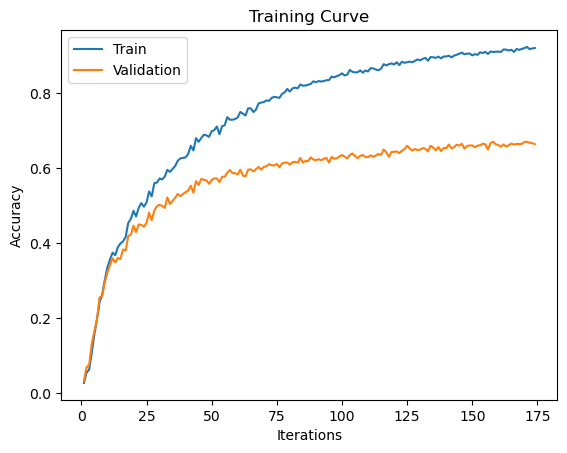

In [265]:
# Create an instance of the model.
model = SpecCNN(num_classes=num_classes, dropout_rate=0.65)

# Move the model to GPU if available.
model.to(device)

# Train the model
train_acc, val_acc = train_net(model, batch_size, train_loader, val_loader,
                                   learning_rate = 0.0001, num_epochs = 350)
n = len(train_acc)
plt.title("Training Curve")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

3. Testing of the Model


/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_11770/362716215.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test accuracy: 0.7002
Normalized confusion matrix


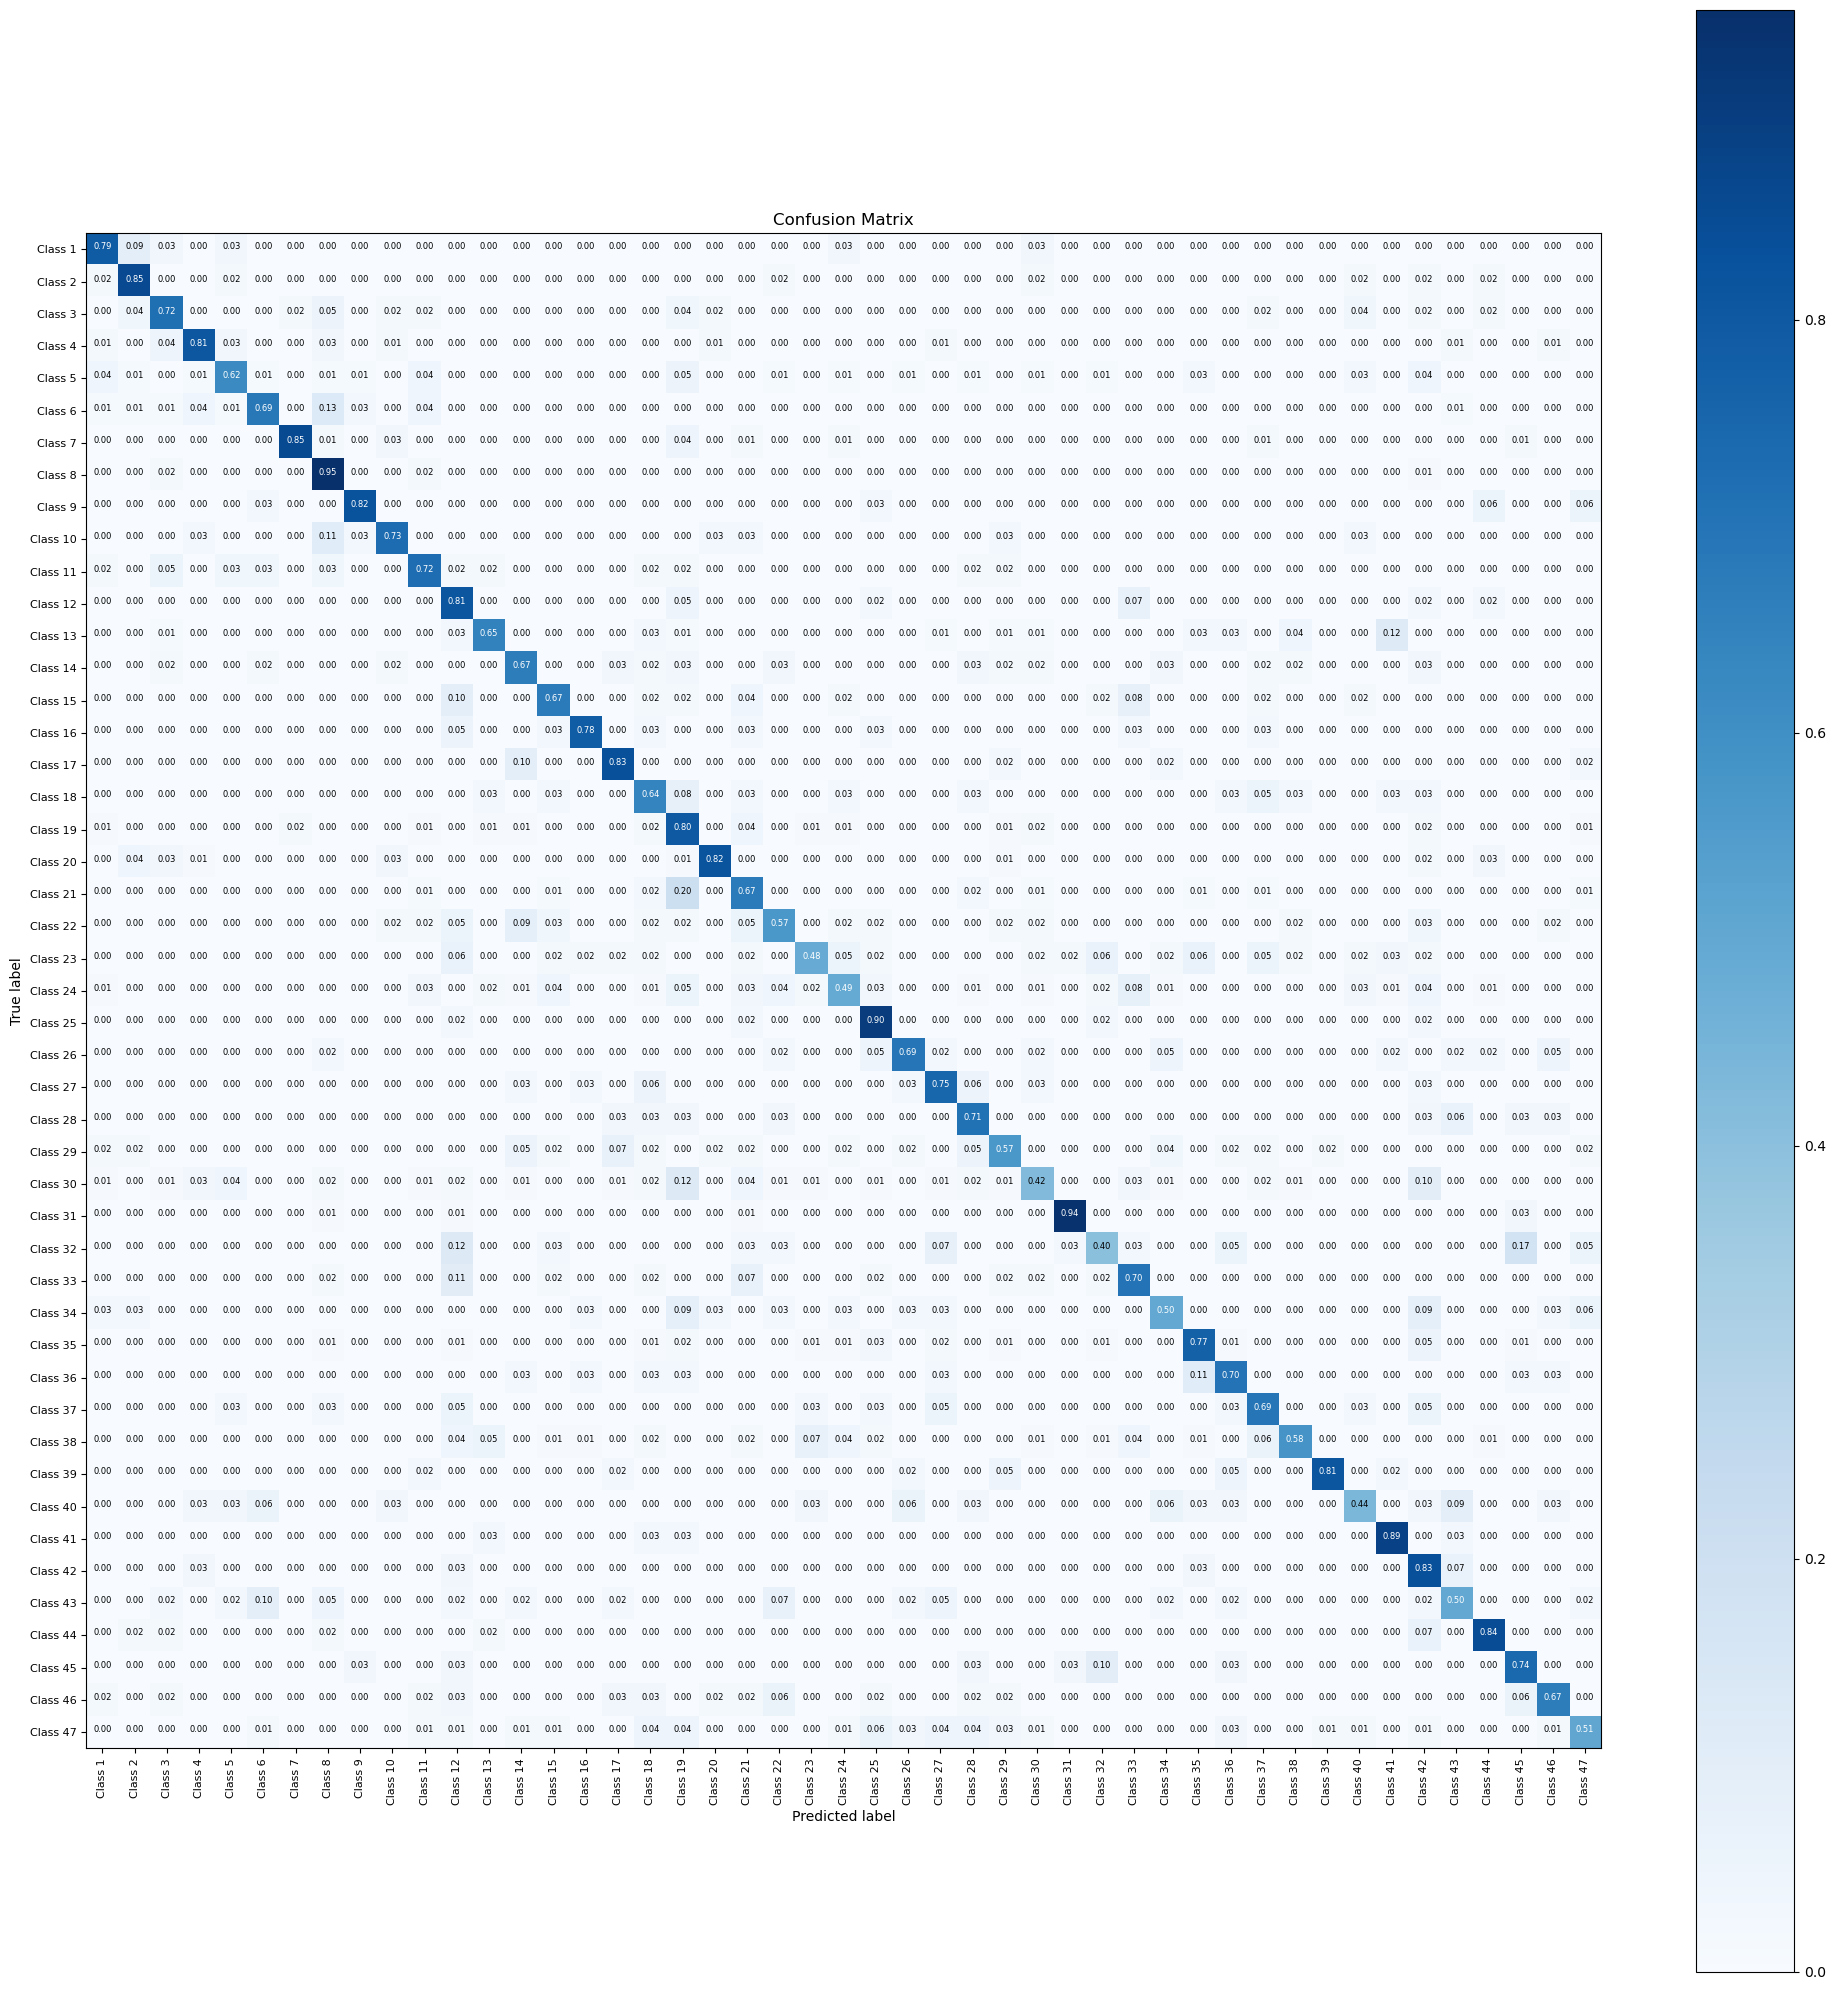

In [26]:
# --- Your testing code ---
# Load the best model.
model = SpecCNN(num_classes=num_classes, dropout_rate=0.65)
model_path = 'Models/best_audio_model.pt'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

correct_test, total_test = 0, 0
predictions = []
pred_labels = []

# Iterate through the test set.
with torch.no_grad():
    for recordings, labels in test_loader:
        recordings = recordings.to(device)
        labels = labels.to(device)
        output = model(recordings)
        pred = output.max(1, keepdim=True)[1]
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        total_test += recordings.shape[0]
        predictions.extend(pred.cpu().numpy())
        pred_labels.extend(labels.cpu().numpy())

# Calculate test accuracy.
test_acc = correct_test / total_test
print(f"Test accuracy: {test_acc:.4f}")

# --- Compute and plot confusion matrix ---
# Convert predictions and true labels to flat arrays.
predictions = np.array(predictions).flatten()
true_labels = np.array(pred_labels).flatten()

# Calculate the confusion matrix (assuming 47 classes).
cm = confusion_matrix(true_labels, predictions, labels=np.arange(47))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix as a heat map.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=8)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=6)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Generate class names (you can replace these with actual bird names if available)
class_names = [f'Class {i+1}' for i in range(47)]

# Plot the normalized confusion matrix.
plot_confusion_matrix(cm, classes=class_names, normalize=True)

In [23]:
# Print out the F1 score.
from sklearn.metrics import f1_score

# Assuming 'true_labels' and 'predictions' are your flattened arrays of true and predicted labels.
f1_weighted = f1_score(true_labels, predictions, average='weighted')

print(f"Weighted F1 Score: {f1_weighted:.4f}")

Weighted F1 Score: 0.7006


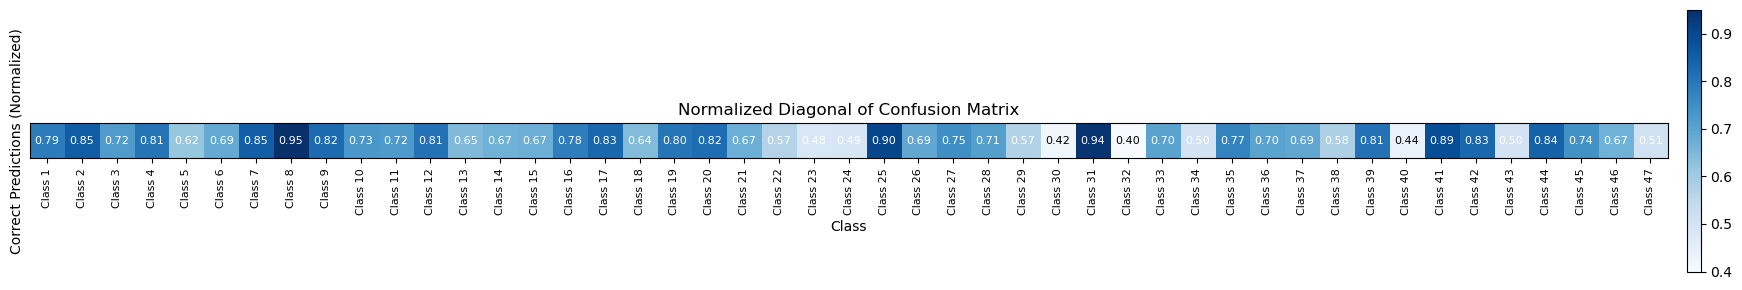

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# Assume you have your true_labels and predictions arrays already computed.
# Calculate the raw confusion matrix for 47 classes.
cm = confusion_matrix(true_labels, predictions, labels=np.arange(47))

# Normalize the confusion matrix row-wise (each row sums to 1).
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Extract the main diagonal (normalized correct prediction percentages for each class)
main_diag_normalized = np.diag(cm_normalized)

# Reshape it into a 1x47 matrix for plotting.
main_diag_row_normalized = main_diag_normalized.reshape(1, -1)

# Plot the row as a heat map.
plt.figure(figsize=(20, 3))
plt.imshow(main_diag_row_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Diagonal of Confusion Matrix")
# Adjust pad to bring the colorbar closer to the main graph.
plt.colorbar(pad=0.01)

# Assuming you have your list of 47 class names.
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90, fontsize=8)
# Remove the left y-axis tick labels.
plt.yticks([])

# Annotate each cell with its normalized decimal value.
for j in range(main_diag_row_normalized.shape[1]):
    value = main_diag_row_normalized[0, j]
    plt.text(j, 0, format(value, '.2f'),
             horizontalalignment="center",
             verticalalignment="center",
             color="white" if value > main_diag_row_normalized.max() / 2.0 else "black",
             fontsize=8)

plt.xlabel('Class')
plt.ylabel('Correct Predictions (Normalized)')
plt.tight_layout()
plt.show()


Misc Stuff for the Report


In [47]:
train_dataset[0][0].shape

torch.Size([1, 128, 128])

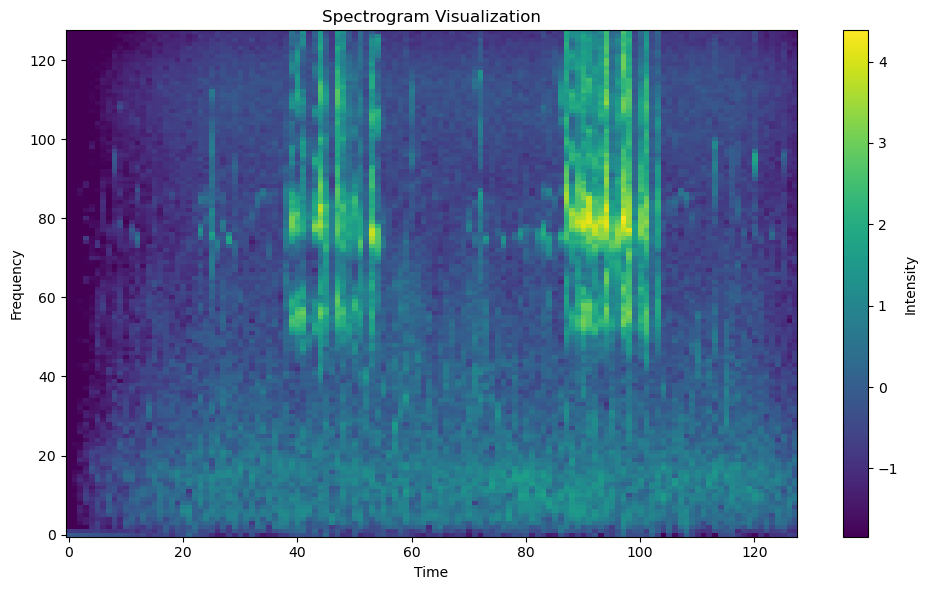

In [54]:
import matplotlib.pyplot as plt

# Get your tensor
spectrogram_tensor = train_dataset[0][0]

# Remove channel dimension and convert to numpy
spectrogram_np = spectrogram_tensor.squeeze(0).numpy()  # shape becomes (128,128)

# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram_np, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram Visualization')
plt.tight_layout()
plt.show()


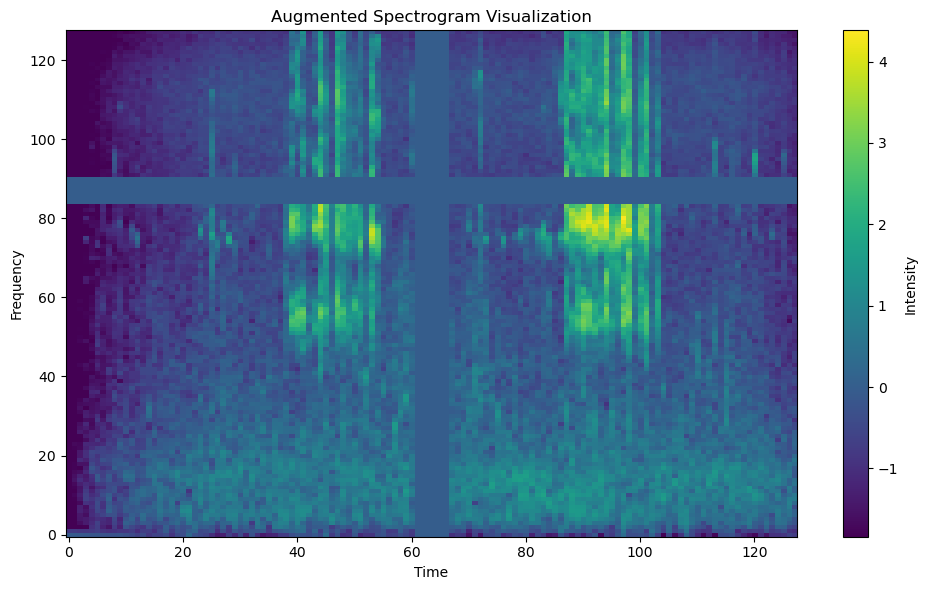

In [55]:
# Now we want to visualise the same spectrogram but with specaugments applied.
# Get the augmented spectrogram
augmented_spectrogram_tensor = augmented_train_dataset[0][0]
# Remove channel dimension and convert to numpy
augmented_spectrogram_np = augmented_spectrogram_tensor.squeeze(0).numpy()  # shape becomes (128,128)
# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(augmented_spectrogram_np, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Augmented Spectrogram Visualization')
plt.tight_layout()
plt.show()


In [57]:
import torch
import numpy as np
from sklearn.metrics import f1_score

# Now we make inferences on the test set.
# Load the best model.
model = SpecCNN(num_classes = num_classes, dropout_rate=0.2)
model_path = 'Models/best_audio_model.pt'
model.load_state_dict(torch.load(model_path))
# Move the model to GPU if available.
model.to(device)
# Set the model to evaluation mode.
model.eval()

correct_test, total_test = 0, 0
predictions = []
true_labels = []

# Iterate through the test set.
with torch.no_grad():
    for recordings, labels in test_loader:
        recordings = recordings.to(device)
        labels = labels.to(device)
        output = model(recordings)
        pred = output.max(1, keepdim=True)[1]
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        total_test += recordings.shape[0]
        # Extend the predictions and true labels lists.
        predictions.extend(pred.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate test accuracy.
test_acc = correct_test / total_test
print(f"Test accuracy: {test_acc:.4f}")

# Convert lists to numpy arrays and flatten if necessary.
predictions = np.array(predictions).flatten()
true_labels = np.array(true_labels).flatten()

# Compute the weighted F1 score.
weighted_f1 = f1_score(true_labels, predictions, average='weighted')
print(f"Weighted F1 Score: {weighted_f1:.4f}")

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_11770/213034604.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test accuracy: 0.7002
Weighted F1 Score: 0.7006


In [66]:
import torch
import random
import matplotlib.pyplot as plt

def sample_and_predict(model, test_loader, device, class_names):
    model.eval()
    samples = []
    labels = []

    # Gather all test data into a single list (for random access)
    all_data = list(test_loader)

    # Randomly pick 3 spectrograms
    while len(samples) < 5:
        for inputs, targets in all_data:
            idx = random.randint(0, inputs.size(0) - 1)
            samples.append(inputs[idx])
            labels.append(targets[idx])
            if len(samples) == 5:
                break

    samples_tensor = torch.stack(samples).to(device)
    true_labels = torch.tensor(labels)

    # Forward pass
    with torch.no_grad():
        outputs = model(samples_tensor)
        predictions = torch.argmax(outputs, dim=1)

    # Display predictions vs actuals
    for i in range(5):
        plt.figure(figsize=(4, 3))
        plt.imshow(samples[i].squeeze().cpu(), cmap='viridis', aspect='auto')
        plt.title(f"Predicted: {class_names[predictions[i]]} | Actual: {class_names[true_labels[i]]}")
        plt.axis('off')
        plt.show()

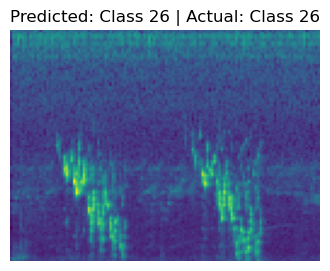

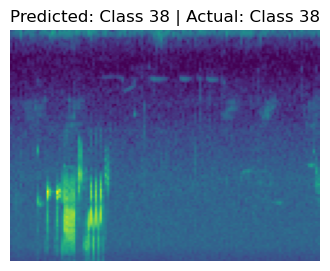

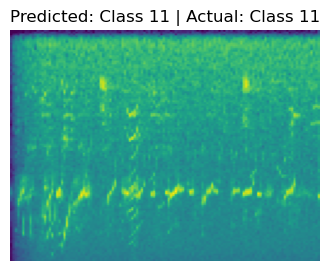

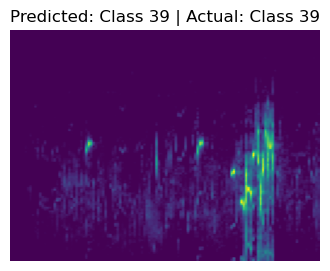

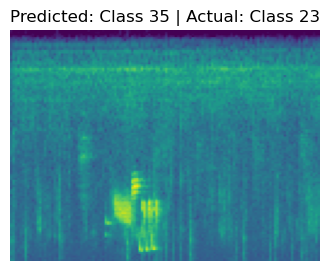

In [69]:
sample_and_predict(model, test_loader, device, class_names)